In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from common import Fonts, Images, NWSL

In [2]:
df = pd.read_csv("2022_2023_movement.csv")
df

,player,team_old,team_new
0,Abbey Burdette,NaN,WAS
1,Abby Boyan,NaN,CHI
2,Abby Dahlkemper,SD,SD
3,Abby Erceg,NC,LOU
4,Abby Smith,POR,NJY
...,...,...,...
411,Wasila Diwura-Soala,NaN,HOU
412,Yazmeen Ryan,POR,NJY
413,Yuki Nagasato,CHI,CHI
414,Zaneta Wyne,LOU,LOU


In [3]:
retained = (
    df[df["team_old"] == df["team_new"]]
    .groupby("team_new")
    .agg(count=("team_new", "count"))
    .sort_values("count", ascending=False)
    .reset_index()
)
retained

,team_new,count
0,HOU,24
1,POR,23
2,RGN,22
3,LOU,20
4,LA,19
5,ORL,19
6,KC,18
7,NJY,18
8,SD,18
9,WAS,17


In [5]:
traded = (
    df[(df["team_old"] != df["team_new"]) & df["team_old"] & df["team_new"]]
    .groupby(["team_new", "team_old"])
    .agg(count=("team_new", "count"))
    .reset_index()
)
traded

,team_new,team_old,count
0,CHI,KC,1
1,CHI,LA,1
2,CHI,NJY,1
3,HOU,LA,1
4,HOU,NC,1
5,HOU,NJY,1
6,HOU,ORL,1
7,HOU,WAS,1
8,KC,CHI,2
9,KC,NC,1


In [6]:
new = (
    df[df["team_old"].isna()]
    .groupby("team_new")
    .agg(count=("team_new", "count"))
    .reset_index()
)
new

,team_new,count
0,CHI,15
1,HOU,13
2,KC,9
3,LA,9
4,LOU,7
5,NC,11
6,NJY,2
7,ORL,8
8,POR,5
9,RGN,4


In [7]:
old = (
    df[df["team_new"].isna()]
    .groupby("team_old")
    .agg(count=("team_old", "count"))
    .reset_index()
)
old

,team_old,count
0,CHI,7
1,HOU,5
2,KC,3
3,LA,6
4,LOU,2
5,NC,3
6,NJY,3
7,ORL,7
8,POR,2
9,RGN,5


<Figure size 720x720 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

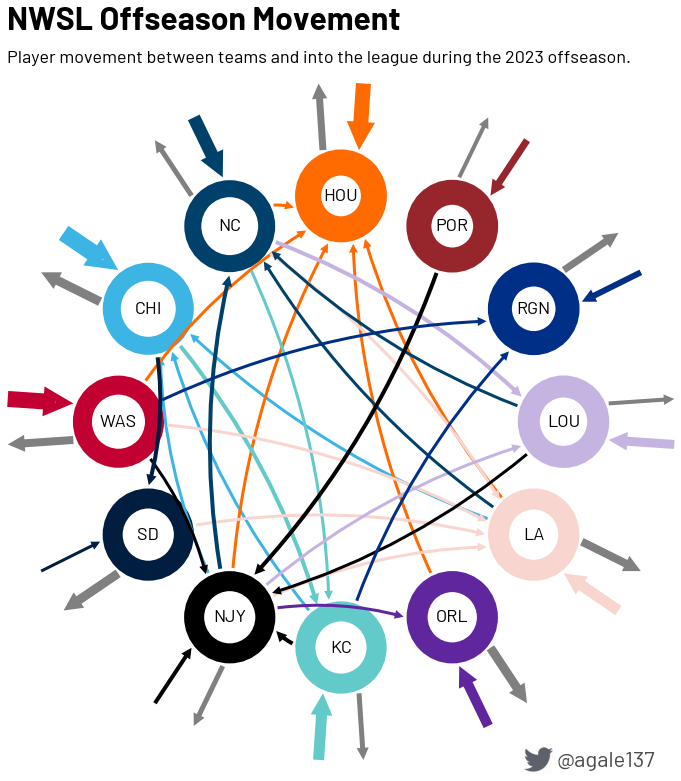

In [131]:
# Constants
outer_radius = 0.3
outer_angle = math.pi / 8
circle_r = 0.2

# Draw the plot
plt.clf()
plt.rcParams["figure.figsize"] = (10, 10)
plt.figure(dpi=200, facecolor="white")
fig, ax = plt.subplots()
fig.tight_layout()
fig.patch.set_facecolor("white")
ax.axis("off")

# Set limits
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

angles = {}


def get_coords(team, r=1):
    angle = angles[team]
    return (math.sin(angle) * r, math.cos(angle) * r)


def move_point_along_line(x1, y1, x2, y2, r):
    """Moves point (x1, y1) a distance r towards (x2, y2)"""

    d = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    t = r / d

    return ((1 - t) * x1 + t * x2, (1 - t) * y1 + t * y2)


def rotate_point(x1, y1, cx, cy, angle):
    """Rotates (x1, y1) around (cx, cy) by angle"""
    x = (x1 - cx) * math.cos(angle) - (y1 - cy) * math.sin(angle)
    y = (x1 - cx) * math.sin(angle) + (y1 - cy) * math.cos(angle)

    return (x + cx, y + cy)


# Plot teams
for i, team in retained.iterrows():
    angle = i * math.pi / 6
    angles[team["team_new"]] = angle
    x, y = get_coords(team["team_new"])
    lw = team["count"] + 2
    r = circle_r - lw / 500
    ax.add_patch(
        patches.Circle((x, y), r, ec=NWSL.color(team["team_new"]), color="white", lw=lw)
    )
    ax.text(x, y, team["team_new"], ha="center", va="center", size=18, fontproperties=Fonts.BARLOW,)

# Plot players who joined the league
for i, team in new.iterrows():
    r = circle_r + 0.01
    cx, cy = get_coords(team["team_new"], 1)
    x2, y2 = get_coords(team["team_new"], r + 1)
    color = NWSL.color(team["team_new"])

    x2a, y2a = rotate_point(x2, y2, cx, cy, -outer_angle)
    x1a, y1a = move_point_along_line(0, 0, x2a, y2a, r + 1 + outer_radius)

    ax.add_patch(
        patches.FancyArrowPatch(
            (x1a, y1a),
            (x2a, y2a),
            arrowstyle="-|>",
            lw=2 + team["count"],
            mutation_scale=10,
            joinstyle="miter",
            capstyle="butt",
            clip_on=False,
            color=color,
            fc=color,
        )
    )

# Plot players who left the league
for i, team in old.iterrows():
    r = circle_r + 0.01
    cx, cy = get_coords(team["team_old"], 1)
    x1, y1 = get_coords(team["team_old"], r + 1)
    color = "gray"

    x1a, y1a = rotate_point(x1, y1, cx, cy, outer_angle)
    x2a, y2a = move_point_along_line(0, 0, x1a, y1a, r + 1 + outer_radius)

    ax.add_patch(
        patches.FancyArrowPatch(
            (x1a, y1a),
            (x2a, y2a),
            arrowstyle="-|>",
            lw=2 + team["count"],
            mutation_scale=10,
            joinstyle="miter",
            capstyle="butt",
            clip_on=False,
            color=color,
            fc=color,
        )
    )

# Plot trades
for i, team in traded.iterrows():
    cx, cy = get_coords(team["team_old"], 1)
    x1, y1 = get_coords(team["team_old"], 1)
    x2, y2 = get_coords(team["team_new"], 1)

    # Adjust intersection with the edge of the circle
    r = circle_r + 0.01
    x1a, y1a = move_point_along_line(x1, y1, x2, y2, r)
    x2a, y2a = move_point_along_line(x2, y2, x1, y1, r)

    x1a, y1a = rotate_point(x1a, y1a, cx, cy, math.pi / 16)

    color = NWSL.color(team["team_new"])

    ax.add_patch(
        patches.FancyArrowPatch(
            (x1a, y1a),
            (x2a, y2a),
            arrowstyle="-|>",
            connectionstyle="arc3,rad=-0.1",
            lw=2 + team["count"],
            mutation_scale=10,
            joinstyle="miter",
            capstyle="butt",
            clip_on=False,
            color=color,
            fc=color,
        )
    )

# Title
plt.title(
    "NWSL Offseason Movement",
    fontproperties=Fonts.BARLOW_BOLD,
    size=32,
    x=0,
    y=1.07,
    ha="left",
)

# Subtitle
fig.text(
    0,
    1.03,
    "Player movement between teams and into the league during the 2023 offseason.",
    fontproperties=Fonts.BARLOW,
    size=18,
    transform=ax.transAxes,
    ha="left",
)

# Twitter logo and username
plt.text(
    0.97,
    0,
    "@agale137",
    transform=ax.transAxes,
    color="black",
    fontsize=22,
    alpha=0.7,
    fontproperties=Fonts.BARLOW,
    va="center",
    ha="right",
)
newax = fig.add_axes([0.765, 0.02, 0.04, 0.04], anchor="SE", zorder=1)
newax.imshow(Images.TWITTER)
newax.axis("off")


# Save image
plt.savefig("2023_offseason.png", bbox_inches="tight", pad_inches=0.5)

222.52916666666664